<a href="https://colab.research.google.com/github/Shnku/pythoning_stuff/blob/proj/NN/build_cnn/expr1_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Gdrive setup

## Mount google-drive & Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#shared path to drive
SHARED_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

#direct path to drive
DIRECT_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = SHARED_PATH if os.path.exists(SHARED_PATH) else DIRECT_PATH if os.path.exists(DIRECT_PATH) else None

DATA_PATH = ''
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    DATA_PATH = root_path + "/Proj1_CGC_Building_with_sides_classify"
    for filename in os.listdir(DATA_PATH):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
img_data
train_df.csv
img_data.csv
test_df.csv
make_csv_data_from_img_folder.ipynb
ResNet18_with_12_accy.pth
ResNet18_with_9_accy.pth
ResNet18_with_13_accy.pth
expr1_resnet18.ipynb


## Importing pytorch and setup CPU or GPU

In [ ]:
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


#### Setup random state

In [ ]:
# define the random seed
SEED = 2025

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

# Data Importing and Modification and Loading

In [ ]:
# path_train_data= DATA_PATH + "/train_df.csv"
# path_test_data= DATA_PATH + "/test_df.csv"
csv_data_path = DATA_PATH + "/img_data.csv"

## Train-Test Split

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load the CSV data into a DataFrame
df = pd.read_csv(csv_data_path)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['class'])

In [ ]:
print('------------ Training set class frequencies ----------------')
print(train_df['class'].value_counts())

------------ Training set class frequencies ----------------
class
gurudeb_front      33
chemistry_front    32
chemistry_right    29
chemistry_left     28
heritage_front     27
admin_front        27
heritage_left      26
admin_right        25
gurudeb_right      24
admin_left         22
gurudeb_left       22
Name: count, dtype: int64


In [ ]:
print('------------ Test set class frequencies ----------------')
print(test_df['class'].value_counts())

------------ Test set class frequencies ----------------
class
chemistry_front    8
gurudeb_front      8
chemistry_right    8
admin_front        7
heritage_front     7
chemistry_left     7
admin_right        7
heritage_left      6
gurudeb_right      6
admin_left         5
gurudeb_left       5
Name: count, dtype: int64


## Define data transformations

In [ ]:
import torchvision.transforms as transforms

mean=[0.485, 0.456, 0.406]
standev=[0.229, 0.224, 0.225]
px=256

train_transform = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

test_transform =  transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

print(train_transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset with Torch

### Custom class foe loading csv data

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # self.dataframe = pd.DataFrame(pd.read_csv(csv_file))
        self.dataframe = dataframe
        self.transform = transform
        # Create a mapping from class name to index
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.dataframe['class'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = DATA_PATH + self.dataframe.iloc[idx]['path']
        label_name = self.dataframe.iloc[idx]['class']

        # read_image returns a tensor with shape [C, H, W]
        image = Image.open(img_path).convert('RGB') #RGB channel must
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        # Convert label name to index
        label = self.class_to_idx[label_name]

        return image, label


### Load csv with torch with transformation applied

In [ ]:
# load
train_dataset = CustomImageDataset(dataframe=train_df, transform=train_transform)
test_dataset = CustomImageDataset(dataframe=test_df, transform=test_transform)

## Data loader

### Define ***Batch-Size (Hyper-parameter)***

In [ ]:
BATCH_SIZE = 2

### Create DataLoader instances

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(train_loader)
print(test_loader)

# Example of iterating through the DataLoader
print(train_dataset.class_to_idx)
print(len(train_dataset.class_to_idx))
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break # Just show one batch


{'gurudeb_front': 0, 'heritage_front': 1, 'chemistry_left': 2, 'chemistry_front': 3, 'chemistry_right': 4, 'gurudeb_left': 5, 'admin_left': 6, 'gurudeb_right': 7, 'heritage_left': 8, 'admin_right': 9, 'admin_front': 10}
11


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch of images shape: torch.Size([2, 3, 224, 224])
Batch of labels shape: torch.Size([2])


### Visualization of transformation

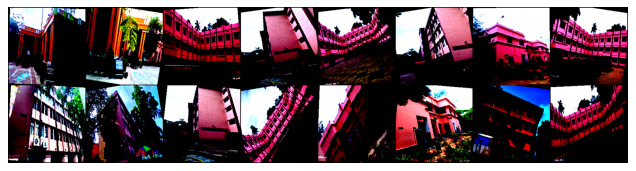

labels: tensor([ 1,  1,  7,  9,  0,  9,  2,  5, 10,  6,  9,  0,  3,  4,  6,  0])


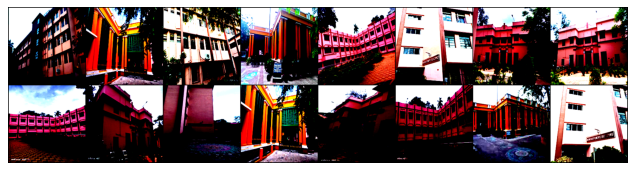

labels: tensor([ 1,  7,  1,  3,  8,  5,  0,  0,  4, 10,  5,  7,  9,  4,  3,  5])


In [ ]:
def disp_img_grid(dataset, mean, std):
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    batch = next(iter(loader))
    img, lbl = batch

    grid = torchvision.utils.make_grid(img, nrow=8) # Changed nrow to 4 for better visualization of multiple images
    plt.figure(figsize=(10, 10), dpi=80)
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')  # Hide axes
    plt.show()  # Show the plot
    print(f'labels: {lbl}')

# Example usage with your custom datasets:
# Pass the dataset objects and the mean and std used for normalization
disp_img_grid(train_dataset, mean=mean, std=standev)
disp_img_grid(test_dataset, mean=mean, std=standev)

# CNN Defining and Training part

## Use Readymade CNN Model(ResNet) and modify it

In [ ]:
# Load torch's ResNet18 model
import torchvision.models as models
import torch.nn as nn

# CNN_MODEL = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True/false
CNN_MODEL = models.resnet18(weights = None) # pretrained = False)
# CNN_MODEL = models.efficientnet_b4(weights = '') # pretrained = False)

### Model's Weights and biases Initialization

In [ ]:
import torch.nn.init as init

# with torch.no_grad():
for module in CNN_MODEL.modules():
    if isinstance(module, nn.Linear):
        init.kaiming_normal_(
            module.weight, a=0, mode='fan_out', nonlinearity='relu',
        )
        if module.bias is not None:
            fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
            bound = 1 / (fan_out)**0.5
            init.normal_(module.bias, -bound, bound)

### We have to modify the last layer

In [ ]:
# modifying the last layer
# ResNet models have a 'fc' layer as the last linear layer
last_layer_in = CNN_MODEL.fc.in_features
no_of_classes = len(train_dataset.class_to_idx)
print(f"last layer output for model = {last_layer_in} -> convert to {no_of_classes} output")

# CNN_MODEL.fc = nn.Linear(last_layer_in, no_of_classes)
CNN_MODEL.fc = nn.Sequential(
    torch.nn.Linear(in_features=last_layer_in, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(
        in_features=256,
        out_features=len(train_dataset.class_to_idx),
    ),
    torch.nn.Softmax(dim=1),
)

last layer output for model = 512 -> convert to 11 output


### Send the model to GPU/CPU

In [ ]:
# Move model to device
CNN_MODEL = CNN_MODEL.to(DEVICE)
print(CNN_MODEL)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define loss function

In [ ]:
# criterion = torch.nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss()
print(loss_fn)

CrossEntropyLoss()


### Define ***Hyper-parameter(learning rate)***

In [ ]:
# set hyperparameter
LEARNING_RATE = 0.001

### Define optimaizer

In [ ]:
import torch.optim as optim

# define optimizer (Adam, SGD, Adagard)
optimizer = optim.Adam(CNN_MODEL.parameters(), lr=LEARNING_RATE) # lr = learning rate
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Defining functions for train and validation

### function for training

In [ ]:
# from tqdm import tqdm
# In your train_NN function, after defining the optimizer:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Example scheduler

def train_NN(model, train_loader, test_loader, loss_function, optim, n_epochs=10):
    loss_graph_list, accy_list, valid_loss_list = [], [], [] # Changed variable name to avoid conflict
    for epoch in (range(n_epochs)):
        model.train()  # Set the model to training mode
        training_loss = [] # list to store the training loss for each batch

        for i_image, i_label in train_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            optimizer.zero_grad() # Zero out the gradients to prevent accumulation
            output = model(i_image) # Get the model's output for the current batch of imgs
            loss = loss_function(output, i_label) # Calculate the loss using the defined loss function
            loss.backward()  # Perform backpropagation to compute gradients
            optimizer.step()  # Update the model's weights using the optimizer

            training_loss.append(loss.item())

        print(f"Training loss at iteration--{epoch+1} is:- {np.mean(training_loss)}")
        accy, current_valid_loss = eval_model_on_test(model, test_loader, loss_function) # Capture validation loss
        loss_graph_list.append(np.mean(training_loss))
        valid_loss_list.append(current_valid_loss) # Append the captured validation loss
        accy_list.append(accy)
    print("Training done.....................")
    return loss_graph_list, accy_list, valid_loss_list # Return the list of validation losses

### Function for validation test

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def eval_model_on_test(model, test_loader, loss_function=loss_fn, display_labels=test_dataset.class_to_idx, disp_confusion_matrix=False):
    model.eval()  # Set the model to evaluation mode
    pred_correctly = 0
    total = 0
    actual_labels = []
    predicted_labels = []
    validation_loss = [] # list to store the validation loss for each batch

    with torch.no_grad():
        for i_image, i_label in test_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            total += i_label.size(0) # number of samples in the current batch
            output = model(i_image)

            # Calculate validation loss
            loss = loss_function(output, i_label)
            validation_loss.append(loss.item())

            # get predicted class index (max probability) for each image in the batch
            _, predicted = torch.max(output.data, 1) # its indx along (dimension 1,which corresponds to the class scores).
            pred_correctly += (predicted == i_label).sum().item() # total count of correctly predicted samples.

            # Collect actual_labels & pridected_labels for confusion matrix
            actual_labels.extend(i_label.cpu().numpy()) # tensor -> NP array and extending the list.
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100.0 * pred_correctly / total
    average_validation_loss = np.mean(validation_loss) # Calculate the average validation loss
    print(f'--Validation loss:- {average_validation_loss}', end='') # Print the validation loss
    print(f' --Testing....got-({pred_correctly}/{total})-correctly-->>accuracy=({accuracy:.2f}%)')


    # Generate and display confusion matrix
    if disp_confusion_matrix:
        ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix(actual_labels, predicted_labels),
            display_labels=display_labels
        ).plot()
        plt.xticks(rotation=90)
        plt.show()
    return accuracy, average_validation_loss # Return both accuracy and validation loss

## Doing train

tune hyperparameter for experiment

- random state [change SEED](#scrollTo=Setup_random_state)
- batch size [change BATCH SIZE](#scrollTo=Define_Batch_Size_Hyper_parameter_)
- learning rate [change LEARNING RATE](#scrollTo=Define_Hyper_parameter_learning_rate_)
- no of epoches or iteration


In [ ]:
# Set no of epoches or train iteration
ITERATION = 20
# call train funtion
iter_loss, iter_accy, valid_loss = train_NN(
    CNN_MODEL, train_loader, test_loader, loss_fn, optimizer, n_epochs=ITERATION,
)

Training loss at 1 iteration is 2.4127..
 --Validation loss: 2.4242 --Testing....got-(7/74)-correctly-->>accuracy=(9.46%)
Training loss at 2 iteration is 2.4183..
 --Validation loss: 2.4073 --Testing....got-(8/74)-correctly-->>accuracy=(10.81%)
Training loss at 3 iteration is 2.3912..
 --Validation loss: 2.3861 --Testing....got-(9/74)-correctly-->>accuracy=(12.16%)
Training loss at 4 iteration is 2.3754..
 --Validation loss: 2.4094 --Testing....got-(7/74)-correctly-->>accuracy=(9.46%)
Training loss at 5 iteration is 2.4195..
 --Validation loss: 2.3802 --Testing....got-(10/74)-correctly-->>accuracy=(13.51%)
Training loss at 6 iteration is 2.3807..
 --Validation loss: 2.3937 --Testing....got-(10/74)-correctly-->>accuracy=(13.51%)
Training loss at 7 iteration is 2.3839..
 --Validation loss: 2.3933 --Testing....got-(7/74)-correctly-->>accuracy=(9.46%)
Training loss at 8 iteration is 2.3825..
 --Validation loss: 2.4050 --Testing....got-(9/74)-correctly-->>accuracy=(12.16%)
Training loss at 

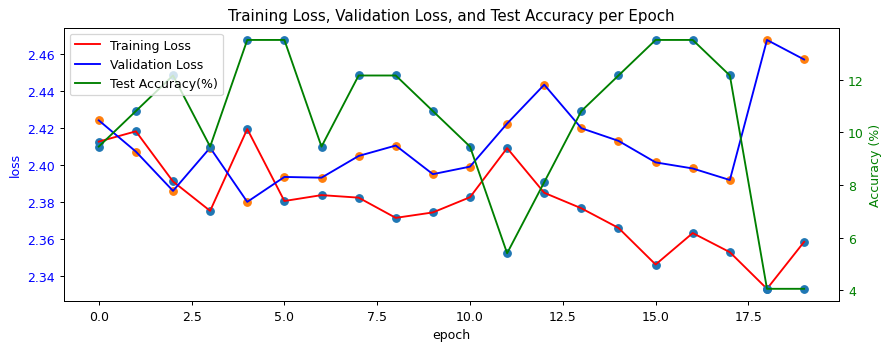

In [ ]:
import matplotlib.pyplot as plt

def ploting(ax, arr, color,lname, ylabel='loss', xlabel='epoch'):
    ax.plot(arr, color=color, label=lname)
    ax.scatter(range(len(arr)),arr)
    ax.set_ylabel(ylabel, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xlabel(xlabel)


# Create a figure and the first axes
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=90)
# Create a second axes that shares the same x-axis as the first
ax2 = ax1.twinx()

# Plotting loss and valid loss on ax1 (left y-axis)
ploting(ax1, iter_loss, color='red', lname='Training Loss')
ploting(ax1, valid_loss, color='blue', lname='Validation Loss')
# Plotting accuracy on ax2 (right y-axis)
ploting(ax2, iter_accy, color='green', lname='Test Accuracy(%)',ylabel='Accuracy (%)')

# Add a legend: Combine handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# Create a single legend for all lines
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.title('Training Loss, Validation Loss, and Test Accuracy per Epoch')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Validate the model

 --Validation loss: 2.4570 --Testing....got-(3/74)-correctly-->>accuracy=(4.05%)


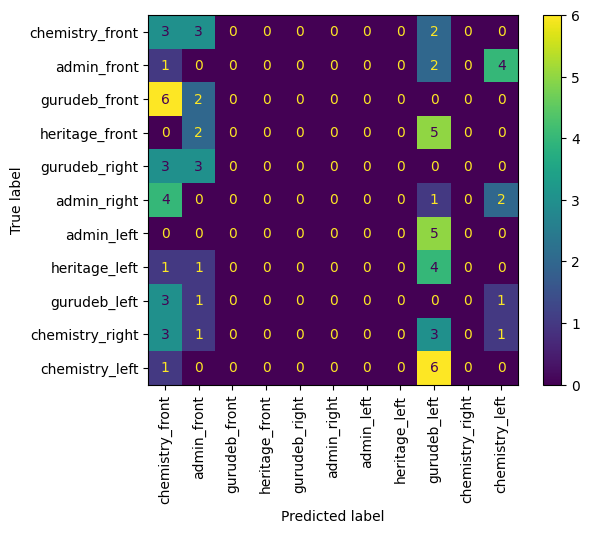

In [ ]:
# call evaluation function
accuracy,_ = eval_model_on_test(
    CNN_MODEL, test_loader, disp_confusion_matrix=True,
)

## Save trained model

In [ ]:
# print(CNN_MODEL.state_dict())
# torch.save(CNN_MODEL.state_dict(), DATA_PATH +'/resnet18_image_classifier.pth')

#save entire model
model_name = CNN_MODEL.__class__.__name__ + '18'
print(model_name)

torch.save(CNN_MODEL, DATA_PATH+'/'+model_name+'_with_'+ str(int(accuracy))+'_accy.pth')

os.listdir(DATA_PATH)

ResNet18


['img_data',
 'train_df.csv',
 'img_data.csv',
 'test_df.csv',
 'make_csv_data_from_img_folder.ipynb',
 'ResNet18_with_12_accy.pth',
 'ResNet18_with_9_accy.pth',
 'ResNet18_with_13_accy.pth',
 'expr1_resnet18.ipynb',
 'ResNet18_with_4_accy.pth']

# Individual testing

## Predefined parameters

In [ ]:
# MODEL = DATA_PATH+"/resnet18_image_classifier_full.pth"
MODEL = CNN_MODEL
TRANSFORM = test_transform
# Update the CATEGORIES variable to be a list of keys
CATEGORIES = list(test_dataset.class_to_idx.keys())
print(CATEGORIES)


['chemistry_front', 'admin_front', 'gurudeb_front', 'heritage_front', 'gurudeb_right', 'admin_right', 'admin_left', 'heritage_left', 'gurudeb_left', 'chemistry_right', 'chemistry_left']


## Function for individual image classification

In [ ]:
from PIL import Image

def classify_this_image(img_path, model=MODEL,img_transform=TRANSFORM,classes=CATEGORIES):
    model.eval() # set model to evaluation/testing mode
    input_img = Image.open(DATA_PATH + img_path)

    plt.figure(figsize=(10, 10),dpi=30)
    plt.imshow(input_img) # display the loaded image
    plt.axis('off')
    plt.show()

    img_tensor = img_transform(input_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        print(probabilities)
        _, predicted_class_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_class_index.item()]
        print(f"Predicted class: {predicted_class}")

## Input image and Classify

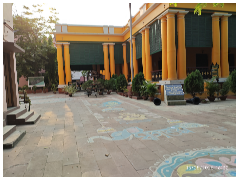

tensor([[0.1757, 0.0875, 0.0831, 0.0832, 0.0812, 0.0806, 0.0810, 0.0806, 0.0807,
         0.0826, 0.0839]])
Predicted class: chemistry_front


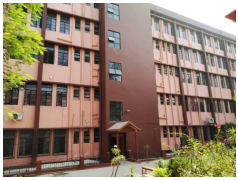

tensor([[0.0889, 0.0848, 0.0805, 0.0808, 0.0806, 0.0804, 0.0805, 0.0804, 0.0804,
         0.0832, 0.1795]])
Predicted class: chemistry_left


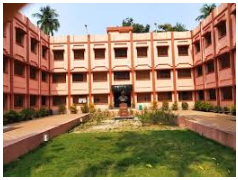

tensor([[0.2081, 0.0793, 0.0806, 0.0793, 0.0790, 0.0789, 0.0789, 0.0789, 0.0789,
         0.0790, 0.0790]])
Predicted class: chemistry_front


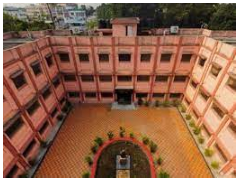

tensor([[0.0787, 0.0789, 0.0787, 0.0787, 0.0787, 0.0787, 0.0787, 0.0787, 0.2132,
         0.0787, 0.0787]])
Predicted class: gurudeb_left


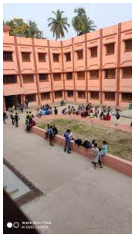

tensor([[0.2137, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786,
         0.0786, 0.0786]])
Predicted class: chemistry_front


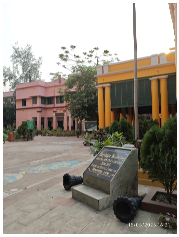

tensor([[0.2061, 0.0796, 0.0812, 0.0795, 0.0791, 0.0791, 0.0791, 0.0791, 0.0791,
         0.0791, 0.0791]])
Predicted class: chemistry_front


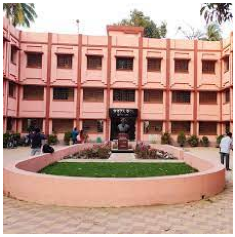

tensor([[0.2137, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786,
         0.0786, 0.0786]])
Predicted class: chemistry_front


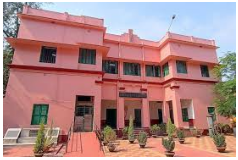

tensor([[0.2137, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786,
         0.0786, 0.0786]])
Predicted class: chemistry_front


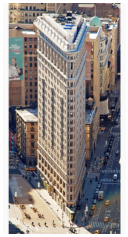

tensor([[0.0789, 0.0793, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0788, 0.0790,
         0.0792, 0.2109]])
Predicted class: chemistry_left


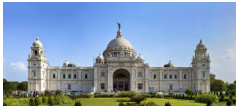

tensor([[0.1131, 0.1148, 0.1090, 0.0830, 0.0833, 0.0823, 0.0828, 0.0822, 0.0847,
         0.0823, 0.0824]])
Predicted class: admin_front


In [ ]:
# Call the classification function
classify_this_image("/../Testing_data_mix/Heritage_test/fview_0001.jpg")
classify_this_image("/../Testing_data_mix/Admin_test/campus-admin-building.jpg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (2).jpeg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (3).jpeg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (4).jpeg")
classify_this_image("/../Testing_data_mix/Heritage_test/Copy of diagonal_0002.jpg")
classify_this_image("/../Testing_data_mix/Gurudeb_test/images (5).jpeg")
classify_this_image("/../Testing_data_mix/Chemistry_test/images (8).jpeg")
classify_this_image("/../Testing_data_mix/Unknown_test/flatiron.jpeg")
classify_this_image("/../Testing_data_mix/Unknown_test/victoria.jpeg")

In [ ]:
# GradCAM